<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/Berryman_SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Effective elastic moduli for multi-component composite using Berryman’s Consistent

***Rock physics, p.185 : Self-consistent approximations of effective moduli***

Berryman (1980b, 1995) - is one of the Self-consistent approach as Budiansky, 1965; Hill, 1965; Wu, 1966.

Berryman equations are coupled and must be solved by simultaneous iteration.
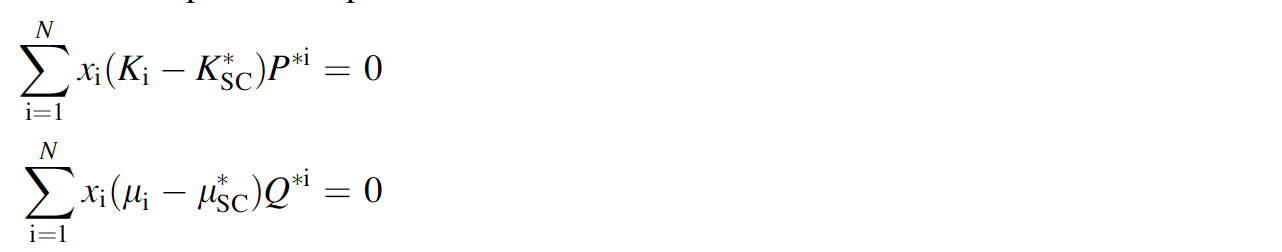

**Assumptions and limitations:**

+ general form of the self-consistent approximations for N-phase composites;
+ for isotropic, linear, elastic media;
+ Самосогласованный метод подходит для сред, где нет четко выраженной матрицы.
+ Изотропный случай: предполагается, что композит является изотропным со случайно ориентированными эллипсоидальными включениями.

- Berryman's self-consistent method **does not converge for fluid disks (Disk --> AR=1)** ($\mu$=0), the formulas for penny-shaped (= penny-cracks , AR $<$ 1) fluid-filled cracks are generally not singular and converge rapidly. However, his estimates for needles, disks, and penny cracks should be used cautiously for fluid-saturated composite materials.

  **Dry cavities??** (=изолированные пустоты) can be modeled by setting the inclusion moduli to zero. Fluidsaturated cavities are simulated by setting the inclusion shear modulus to zero.

+ Apply to simulates very-high-frequency saturated rock behavior (ultrasonic laboratory conditions).

  Because the cavities are isolated with respect to flow, this approach simulates very-high-frequency saturated rock behavior appropriate to ultrasonic laboratory conditions. At low frequencies, when there is time for wave-induced pore-pressure increments to flow and equilibrate, it is better to find the effective moduli for dry cavities and then saturate them with the Gassmann low-frequency relations. This should not be confused with the tendency to term this approach a low-frequency theory, for crack dimensions are assumed to be much smaller than a wavelength.

+ **Анизотропный случай**: В анизотропном случае метод приводит к
системе уравнений, число которых равно числу констант для эквивалентной упругой среды (*Shermergor*). Однако, как было отмечено, например, в работе (*Kachanov M. Eff ective elastic properties of cracked solids: critical
review of some b asic concepts // Applied Mechanics Reviews, 1992, V.45,
issue 8, pp. 304–335*), данный метод переоценивает влияния включений. В случае концентраций пор больших 0,5 метод приводит к отрицательным значениям модулей упругости: ре-
зультат лежит вне вилки Хашина-Штрикмана. В случае высокой концентрации трещин, модули Юнга, объема и сдвига становятся отрицательными, а коэффициент Пуассона превышает 0,5 для насыщенных трещин.




In [73]:
!pip install GitPython
from git import Repo
!git clone https://github.com/MariiaKalinina/Elasticity.git NewElastic

fatal: destination path 'NewElastic' already exists and is not an empty directory.


In [74]:
from math import*
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

### Calculation part


Self-consistent approximations of effective moduli: Berryman (1980b, 1995), isotropic case.

If $\alpha$ = 1, then apply $\alpha$ = 0.9999 or $\alpha$ = 1.000001

In [75]:
def prolate_common(K_i, Mu_i, AR, K_it, Mu_it): ### --> AR>1


    func_teta = (AR * ((AR ** 2-1) ** (-3 / 2))) * (AR * (AR ** 2-1) ** 0.5-np.arccosh(AR))
    func_f = AR ** 2 * (1-AR ** 2) ** -1 * (3 * func_teta-2)


    v_m = (3 * K_it-2 * Mu_it) / (6 * K_it+2 * Mu_it) ### < -- Poisson ration
    R = (1 - 2*v_m) / (2 *(1-v_m))

    A = Mu_i / Mu_it - 1
    B = 1/3 * ((K_i / K_it)-(Mu_i / Mu_it))

    F1 = 1+A * (1.5 * (func_f+func_teta)-R * (1.5 * func_f+2.5 * func_teta-4 / 3))
    F2 = 1+A * (1+1.5 * (func_f+func_teta)-0.5 * R * (3 * func_f+5 * func_teta))+ \
           B * (3-4 * R)+0.5 * A * (A+3 * B) * (3-4 * R) * (
                   func_f+func_teta-R * (func_f-func_teta+2 * func_teta ** 2))
    F3 = 1+A * (1-(func_f+1.5 * func_teta)+R * (func_f+func_teta))
    F4 = 1+0.25 * A * (func_f+3 * func_teta-R * (func_f-func_teta))
    F5 = A * (-func_f+R * (func_f+func_teta-4 / 3))+B * func_teta * (3-4 * R)
    F6 = 1+A * (1+func_f-R * (func_f+func_teta))+B * (1-func_teta) * (3-4 * R)
    F7 = 2+0.25 * A * (3 * func_f+9 * func_teta-R * (3 * func_f+5 * func_teta))+B * func_teta * (3-4 * R)
    F8 = A * (1-2 * R+0.5 * func_f * (R-1)+0.5 * func_teta * (5 * R-3))+B * (1-func_teta) * (3-4 * R)
    F9 = A * ((R-1) * func_f-R * func_teta)+B * func_teta * (3-4 * R)


    P = 1/3 * (3*F1 / F2)
    Q = 1 / 5 * (2 / F3+1 / F4+((F4 * F5+F6 * F7-F8 * F9) / (F2 * F4)))

    return P, Q


def oblate_common(K_i, Mu_i, AR, K_it, Mu_it): ### < --- oblate - AR < 1
                                              ### <-- K_i, Mu_i: components of medium
                                              ### <-- K_it, Mu_it: effective moduls, that iterate

    func_teta = AR / ((1-AR ** 2) ** (3/2)) * (np.arccos(AR) - AR * (1-AR ** 2) ** 0.5)
    func_f = (AR ** 2 / (1-AR ** 2)) * (3 * func_teta-2)

    v_m = (3 * K_it-2 * Mu_it) / (6 * K_it + 2 * Mu_it)
    R = (1-2 * v_m) / (2 * (1-v_m))

    A = (Mu_i / Mu_it)-1
    B = 1 / 3 * ((K_i / K_it)-(Mu_i / Mu_it))

    F1 = 1+A * (1.5 * (func_f+func_teta)-R * (1.5 * func_f+2.5 * func_teta-4 / 3))
    F2 = 1+A * (1+1.5 * (func_f+func_teta)-0.5 * R * (3 * func_f+5 * func_teta))+ \
           B * (3-4 * R)+0.5 * A * (A+3 * B) * (3-4 * R) * (func_f+func_teta-R * (func_f-func_teta+2 * func_teta ** 2))
    F3 = 1+A * (1-(func_f+1.5 * func_teta)+R * (func_f+func_teta))
    F4 = 1+0.25 * A * (func_f+3 * func_teta-R * (func_f-func_teta))
    F5 = A * (-func_f+R * (func_f+func_teta-4 / 3))+B * func_teta * (3-4 * R)
    F6 = 1+A * (1+func_f-R * (func_f+func_teta))+B * (1-func_teta) * (3-4 * R)
    F7 = 2+0.25 * A * (3 * func_f+9 * func_teta-R * (3 * func_f+5 * func_teta))+B * func_teta * (3-4 * R)
    F8 = A * (1-2 * R+0.5 * func_f * (R-1)+0.5 * func_teta * (5 * R-3))+B * (1-func_teta) * (3-4 * R)
    F9 = A * ((R-1) * func_f-R * func_teta)+B * func_teta * (3-4 * R)

    P = 1/3 * (3*F1/F2)
    Q = 1/5 * (2/F3 + 1/F4 + ((F4 * F5 + F6 * F7 - F8 * F9) / (F2 * F4)))

    return P, Q

In [76]:
def effective_modulus(AR_mtrx, AR_fluid, K_it, Mu_it, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por):

  P_mtrx, Q_mtrx = 0, 0
  P_fl, Q_fl = 0, 0

  if AR_mtrx < 1:
    P_mtrx, Q_mtrx = oblate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  elif AR_mtrx == 1:
    AR_mtrx = 1.00001
    P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)
  else:
     P_mtrx, Q_mtrx = prolate_common(K_matrix, Mu_matrix, AR_mtrx, K_it, Mu_it)


  if AR_fluid < 1:
    P_fl, Q_fl = oblate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)
  elif AR_fluid == 1:
    AR_fluid = 1.00001
    P_fl, Q_fl = prolate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)
  else:
    P_fl, Q_fl = prolate_common(K_fluid, Mu_fluid, AR_fluid, K_it, Mu_it)



  Mu = (((1-por) * Mu_matrix * Q_mtrx)+(por * Mu_fluid * Q_fl)) / (
            (1-por) * Q_mtrx + por * Q_fl)  # эффективный модуль сдвига


  K = (((1-por) * K_matrix * P_mtrx)+(por * K_fluid * P_fl)) / (
            (1-por) * P_mtrx + por * P_fl)  # эффективный модуль сжатия


  return K, Mu

In [77]:
def main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por):

  K, Mu = 0, 0

  x0, x1 = K_matrix, Mu_matrix ### <--- first initialization
  K_eff, Mu_eff = effective_modulus(AR_mtrx, AR_fluid, x0, x1, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)


  while abs(x0-K_eff) and abs(x1-Mu_eff) >= eps:
    # print(x0, x1, K_eff, Mu_eff)
    x0, x1 = K_eff, Mu_eff
    K_eff, Mu_eff = effective_modulus(AR_mtrx, AR_fluid, x0, x1, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K, Mu = K_eff, Mu_eff

  return K, Mu

In [78]:
### Initial data

porosity_range = np.linspace(0.1, 0.1, 1, endpoint=True)
eps = 10**-8  ### точность вычислений в методе самосогласования

# K_fluid, Mu_fluid, pfl  = 0.26, 10**-12, 1.04
# K_matrix, Mu_matrix, pm = 78.18, 27.23, 2.71
# AR_mtrx, AR_fluid = 0.9999, 0.1

K_fluid, Mu_fluid, pfl  = 2.25, 10**-20, 1.04
K_matrix, Mu_matrix, pm = 74.47, 31.99, 2.71
AR_mtrx, AR_fluid = 1, 1

In [79]:
K_value, Mu_value = [], []

for por in porosity_range:

  K, Mu = main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K_value.append(K)
  Mu_value.append(Mu)

### Visualization

In [ ]:
# K_fluid, Mu_fluid, pfl  = 10**-6, 10**-6, 1.22 ### air
# K_matrix, Mu_matrix, pm = 53.91, 27.23, 2.71

K_fluid, Mu_fluid, pfl  = 2.25, 10**-20, 1.04 ### water
K_matrix, Mu_matrix, pm = 63.66, 28.62, 2.71

AR_mtrx, AR_fluid = 1, 1
K_value_1, Mu_value_1 = [], []
porosity_range = np.linspace(0., 1, 100, endpoint=True)

for por in porosity_range:

  K, Mu = main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K_value_1.append(K)
  Mu_value_1.append(Mu)

AR_mtrx, AR_fluid = 1.00001, 0.1
K_value_01, Mu_value_01 = [], []

for por in porosity_range:

  K, Mu = main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K_value_01.append(K)
  Mu_value_01.append(Mu)


AR_mtrx, AR_fluid = 1.00001, 0.01
K_value_001, Mu_value_001 = [], []

for por in porosity_range:

  K, Mu = main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K_value_001.append(K)
  Mu_value_001.append(Mu)

Berryman, Isotropic case


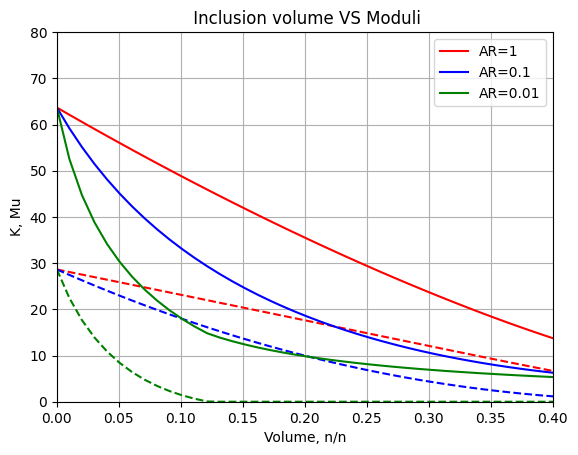

In [ ]:
print(f'Berryman, Isotropic case')

plt.plot(porosity_range, K_value_1, label = 'AR=1', color = 'r')
plt.plot(porosity_range, Mu_value_1, 'r--')

plt.plot(porosity_range, K_value_01, label = 'AR=0.1', color='b')
plt.plot(porosity_range, Mu_value_01, 'b--')

plt.plot(porosity_range, K_value_001, label = 'AR=0.01', color='g')
plt.plot(porosity_range, Mu_value_001, 'g--')

plt.title(f' Inclusion volume VS Moduli')
plt.legend()
plt.xlabel('Volume, n/n')
plt.ylabel(f'K, Mu')
plt.xlim(0, 0.4)
plt.ylim(0, 80)
plt.grid()

In [80]:
def modulus2velosity(density_mtrx, density_fluid, por, K, Mu): ### <-- K, mu to Vp, Vs

    density = density_mtrx * (1-por) + density_fluid * por
    Vp = np.sqrt((K + 4/3*Mu)/ density)
    Vs = np.sqrt(Mu/density)

    return Vp, Vs

In [ ]:
K_value, Mu_value = K_value_01, Mu_value_01

In [ ]:
K_value, Mu_value = K_value_01, Mu_value_01
Vp_value_01, Vs_value_01 = [], []

density_mtrx, density_fluid = pm, pfl

for K,  Mu, porosity in zip(K_value, Mu_value, porosity_range):
  Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)
  Vp_value_01.append(Vp)
  Vs_value_01.append(Vs)

In [ ]:
K_value, Mu_value = K_value_001, Mu_value_001

Vp_value_001, Vs_value_001 = [], []

density_mtrx, density_fluid = pm, pfl

for K,  Mu, porosity in zip(K_value, Mu_value, porosity_range):
  Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)
  Vp_value_001.append(Vp)
  Vs_value_001.append(Vs)

In [ ]:
K_value, Mu_value = K_value_1, Mu_value_1

Vp_value_1, Vs_value_1 = [], []

density_mtrx, density_fluid = pm, pfl

for K,  Mu, porosity in zip(K_value, Mu_value, porosity_range):
  Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)
  Vp_value_1.append(Vp)
  Vs_value_1.append(Vs)

### Наложение экспериментальных данных

In [ ]:
from pathlib import Path
import pandas as pd

path_to_ser = Path('/content/Elasticity/Tver_ver1.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties', skiprows=0)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

# Vp, Vs, porosity  = data['Vp air'], data['Vs air'], data['Porosity,%']/100
Vp_exp, Vs_exp, porosity_exp  = data['Vp water'], data['Vs water'], data['Porosity,%']/100

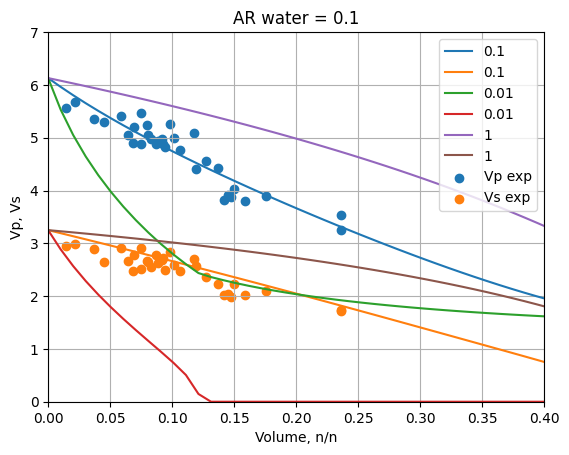

In [ ]:
plt.plot(porosity_range, Vp_value_01, label='0.1')
plt.plot(porosity_range, Vs_value_01, label='0.1')

plt.plot(porosity_range, Vp_value_001, label='0.01')
plt.plot(porosity_range, Vs_value_001, label='0.01')

plt.plot(porosity_range, Vp_value_1, label='1')
plt.plot(porosity_range, Vs_value_1, label='1')

plt.scatter(porosity_exp , Vp_exp, label='Vp exp')
plt.scatter(porosity_exp , Vs_exp, label='Vs exp')

AR_fluid = 0.1
plt.title(f'AR water = {AR_fluid}')
plt.xlim(0, 0.4)
plt.ylim(0, 7)
plt.xlabel('Volume, n/n')
plt.ylabel(f'Vp, Vs')
plt.legend()
plt.grid()

In [ ]:
plt.plot(porosity_range, Vp_value, label='Vp')
plt.plot(porosity_range, Vs_value, label='Vs')

plt.scatter(porosity , Vp, label='Vp exp')
plt.scatter(porosity , Vs, label='Vs exp')

AR_fluid = 0.1
plt.title(f'AR inclusion = {AR_fluid}')
plt.xlim(0, 0.4)
plt.ylim(0, 7)
plt.xlabel('Volume, n/n')
plt.ylabel(f'Vp, Vs')
plt.legend()
plt.grid()

NameError: name 'Vp_value' is not defined

In [ ]:
K_value, Mu_value = [], []

AR_fluid_range = list(np.logspace(-4, 0, num=500, base=10))

AR_mtrx = 1
por = 0.1

for AR_fluid in AR_fluid_range:

  K, Mu = main_Berryman_common(AR_mtrx, AR_fluid, K_matrix, Mu_matrix, K_fluid, Mu_fluid, por)

  K_value.append(K)
  Mu_value.append(Mu)

In [ ]:
print(f'Berryman, Isotropic case')

plt.plot(AR_fluid_range , K_value, color = 'r')
plt.plot(AR_fluid_range , Mu_value, 'r--')


plt.title(f' AR inclusioin VS Moduli')
plt.xlabel('AR incluision (AR matrix=1)')
plt.ylabel(f'K, Mu')
plt.xscale("log")
plt.xlim(10**-4, 10**0)
plt.ylim(0, 80)
plt.grid()

### VRH and Hashin-Strikman bourders

In [ ]:
def VRH (K, μ, f):

    K_voit = (f[0]*K[0]) + (f[1]*K[1])

    K_ross = (f[0]/K[0] + f[1]/K[1])**-1

    K_hill = np.mean([K_voit, K_ross])

    μ_voit = (f[0]*μ[0]) + (f[1]*μ[1])

    μ_ross = (f[0]/μ[0] + f[1]/μ[1])**-1

    μ_hill = np.mean([μ_voit, μ_ross])

    return K_voit, K_ross, K_hill, μ_voit, μ_ross, μ_hill

In [ ]:
def HS_borders(K, μ, f):


  K_up = K[0] + (f[1]/((K[1]-K[0])**-1 +
                        f[0]*(K[0]+4/3*μ[0])**-1))

  K_lo = K[1] + (f[0]/((K[0]-K[1])**-1 +
                        f[1]*(K[1]+4/3*μ[1])**-1))

  K_av = np.mean([K_up, K_lo])

  μ_up = μ[0] + ((f[1])/((μ[1]-μ[0])**-1 +
                          2*f[0]*(K[0]+2*μ[0])/(5*μ[0]*(K[0]+4/3*μ[0]))))

  μ_lo = μ[1] + ((f[0])/((μ[0]-μ[1])**-1 +
                          2*f[1]*(K[1]+2*μ[1])/(5*μ[1]*(K[1]+4/3*μ[1]))))
  μ_av = np.mean([μ_up, μ_lo])

  return K_up, K_lo, K_av, μ_up, μ_lo, μ_av

In [ ]:
porosity = np.linspace(0, 1, 100, endpoint=True)
K_up_value, K_lo_value, K_av_value = [], [], []


for phi in porosity:
  K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
  K_up, K_lo, K_av, _, _, _ = HS_borders(K, μ, f)
  K_up_value.append(K_up)
  K_lo_value.append(K_lo)
  K_av_value.append(K_av)

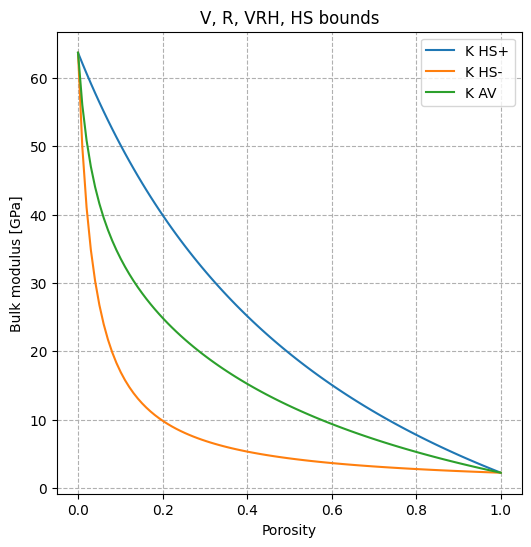

In [ ]:
plt.figure(figsize=(6,6))
plt.xlabel('Porosity')
plt.ylabel('Bulk modulus [GPa]')
plt.title('V, R, VRH, HS bounds')

plt.plot(porosity, K_up_value,label='K HS+')
plt.plot(porosity, K_lo_value,label='K HS-')
plt.plot(porosity, K_av_value,label='K AV')

plt.legend(loc='best')
plt.grid(ls='--')

## Inverse problem: air + water

In [ ]:
def velosity2modulus(density, Vp, Vs): ### <-- K, mu to Vp, Vs

    с_11 = Vp**2*density
    c_44 = Vs**2*density

    mu = c_44
    K = с_11 - 4/3*mu
    print(с_11,c_44, K, mu)

    return K, mu

In [ ]:
Vp_reg_air, Vs_reg_air = 5.77, 3.17
Vp_reg_water, Vs_reg_water = 6.13, 3.25
Vp_reg_oil, Vs_reg_oil = 6.19, 3.39

K_air_mtrx, Mu_air_mtrx = velosity2modulus(2.71, Vp_reg_air, Vs_reg_air)
K_water_mtrx, Mu_water_mtrx = velosity2modulus(2.71, Vp_reg_water, Vs_reg_water)
K_oil_mtrx, Mu_oil_mtrx = velosity2modulus(2.71, Vp_reg_oil, Vs_reg_oil)

90.22375899999999 27.232519 53.91373366666666 27.232519
101.833399 28.624375 63.66756566666667 28.624375
103.83663100000001 31.143591 62.31184300000001 31.143591


In [ ]:
K_oil, Mu_oil, p_oil = 0.26, 10**-12, 1.04
K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air

In [ ]:
def modulus2velosity(density_mtrx, density_fluid, por, K, Mu): ### <-- K, mu to Vp, Vs

    density = density_mtrx * (1-por) + density_fluid * por
    Vp = np.sqrt((K + 4/3*Mu)/ density)
    Vs = np.sqrt(Mu/density)

    return Vp, Vs

### Input Data

In [ ]:
porosity = 14.75/100
Vp_exp_air, Vs_exp_air = 3.45, 1.92
Vp_exp_water, Vs_exp_water = 3.87, 1.98
# density_air, density_water = 2.30, 2.29
density_air, density_water = p_air, p_water
AR = np.logspace(-3, 0, num=71, base=10)
error = 0.05

In [ ]:
AR

array([0.001     , 0.00110372, 0.00121819, 0.00134453, 0.00148398,
       0.00163789, 0.00180777, 0.00199526, 0.0022022 , 0.0024306 ,
       0.0026827 , 0.00296093, 0.00326803, 0.00360697, 0.00398107,
       0.00439397, 0.00484969, 0.00535268, 0.00590784, 0.00652057,
       0.00719686, 0.00794328, 0.00876712, 0.00967641, 0.01068   ,
       0.01178769, 0.01301025, 0.01435962, 0.01584893, 0.01749271,
       0.01930698, 0.02130941, 0.02351953, 0.02595887, 0.0286512 ,
       0.03162278, 0.03490255, 0.03852248, 0.04251786, 0.04692762,
       0.05179475, 0.05716667, 0.06309573, 0.06963974, 0.07686246,
       0.08483429, 0.09363292, 0.10334411, 0.11406249, 0.12589254,
       0.13894955, 0.15336077, 0.16926666, 0.18682224, 0.2061986 ,
       0.22758459, 0.25118864, 0.2772408 , 0.30599497, 0.33773139,
       0.37275937, 0.4114203 , 0.45409096, 0.50118723, 0.55316812,
       0.61054023, 0.67386272, 0.74375273, 0.82089142, 0.90603058,
       1.        ])

In [ ]:
K_air_mtrx, Mu_air_mtrx = 53.91373366666666, 27.232519
K_water_mtrx, Mu_water_mtrx = 63.66756566666667, 28.624375

In [ ]:
fluid_list = ['air', 'water']

for fluid in fluid_list:

    data_fluid = {

    }

    Vp_fluid_list = []
    Vs_fluid_list = []
    AR_list = []
    K_mtrx_var, mu_mtrx_var = [], []

    globals()[f'result_{fluid}'] = pd.DataFrame(data_fluid)


### Matrix range
    globals()[f"K_{fluid}_matix_range"] = [globals()[f"K_{fluid}_mtrx"] - globals()[f"K_{fluid}_mtrx"] * globals()["error"],
                                      globals()[f"K_{fluid}_mtrx"],
                                      globals()[f"K_{fluid}_mtrx"] + globals()[f"K_{fluid}_mtrx"] * 0.05]

    globals()[f"Mu_{fluid}_matix_range"] = [globals()[f"Mu_{fluid}_mtrx"] - globals()[f"Mu_{fluid}_mtrx"] * globals()["error"],
                                      globals()[f"Mu_{fluid}_mtrx"],
                                      globals()[f"Mu_{fluid}_mtrx"] + globals()[f"Mu_{fluid}_mtrx"] * 0.05]


    for ar_inclusion in AR:

      AR_inclusion = ar_inclusion
      AR_mtrx = 1.00001

      for k, mu in zip(globals()[f"K_{fluid}_matix_range"], globals()[f"Mu_{fluid}_matix_range"]):

        AR_list.append(ar_inclusion)

        K_matrix, Mu_matrix = k, mu
        K_mtrx_var.append(K_matrix)
        mu_mtrx_var.append(Mu_matrix)

        K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion, k, mu, globals()[f"K_{fluid}"], globals()[f"Mu_{fluid}"] , porosity)
        density_mtrx, density_fluid = 2.71, globals()[f"density_{fluid}"]
        Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

        Vp_fluid_list.append(Vp)
        Vs_fluid_list.append(Vs)


    globals()[f'result_{fluid}'][f'AR inclusion'] = AR_list

    globals()[f'result_{fluid}'][f'K matrx {fluid}'] = K_mtrx_var
    globals()[f'result_{fluid}'][f'Mu matrx {fluid}'] = mu_mtrx_var

    globals()[f'result_{fluid}'][f'Vp {fluid}'] = Vp_fluid_list
    globals()[f'result_{fluid}'][f'Vs {fluid}'] = Vs_fluid_list



    Vp_exp, Vs_exp = globals()[f"Vp_exp_{fluid}"], globals()[f"Vs_exp_{fluid}"]

### Relative diffrence between calculated and experimntal velocities
    globals()[f'result_{fluid}'][f'Diff Vp {fluid}'] = globals()[f'result_{fluid}'][[f'Vp {fluid}']]\
     .apply(lambda x: np.round((x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)

    globals()[f'result_{fluid}'][f'Diff Vs {fluid}'] =globals()[f'result_{fluid}'][[f'Vs {fluid}']]\
    .apply(lambda x: np.round((x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

### Common relative diffrence between calculated and experimntal velocities
    globals()[f'result_{fluid}'][f'Diff'] = globals()[f'result_{fluid}']\
    .apply(lambda row: np.round(np.sqrt((row[f'Diff Vp {fluid}'])**2 + (row[f'Diff Vs {fluid}'])**2), 2), axis=1)

### Sort values
    globals()[f'result_{fluid}'] = globals()[f'result_{fluid}'].sort_values(by=f'Diff')

In [ ]:

result_air[:10]

,AR inclusion,K matrx air,Mu matrx air,Vp air,Vs air,Diff Vp air,Diff Vs air,Diff
138,0.093633,51.218047,25.870893,3.217952,2.003402,-6.73,4.34,8.01
139,0.093633,53.913734,27.232519,3.301548,2.055447,-4.30,7.05,8.26
137,0.084834,56.609420,28.594145,3.198706,2.005976,-7.28,4.48,8.55
141,0.103344,51.218047,25.870893,3.379782,2.088919,-2.04,8.80,9.03
136,0.084834,53.913734,27.232519,3.121618,1.957633,-9.52,1.96,9.72
140,0.093633,56.609420,28.594145,3.383080,2.106206,-1.94,9.70,9.89
142,0.103344,53.913734,27.232519,3.467583,2.143185,0.51,11.62,11.63
135,0.084834,51.218047,25.870893,3.042577,1.908064,-11.81,-0.62,11.83
144,0.114062,51.218047,25.870893,3.529487,2.165765,2.30,12.80,13.00
134,0.076862,56.609420,28.594145,2.998086,1.893874,-13.10,-1.36,13.17


In [ ]:
result_water[:10]

,AR inclusion,K matrx water,Mu matrx water,Vp water,Vs water,Diff Vp water,Diff Vs water,Diff
124,0.057167,63.667566,28.624375,3.713582,2.031049,-4.04,2.58,4.79
122,0.051795,66.850944,30.055594,3.681795,1.999758,-4.86,1.00,4.96
126,0.063096,60.484187,27.193156,3.735185,2.053147,-3.48,3.69,5.07
125,0.057167,66.850944,30.055594,3.775311,2.073481,-2.45,4.72,5.32
123,0.057167,60.484187,27.193156,3.649868,1.987280,-5.69,0.37,5.70
127,0.063096,63.667566,28.624375,3.802750,2.099094,-1.74,6.01,6.26
121,0.051795,63.667566,28.624375,3.623827,1.959517,-6.36,-1.03,6.44
129,0.069640,60.484187,27.193156,3.819935,2.115747,-1.29,6.86,6.98
119,0.046928,66.850944,30.055594,3.587647,1.922303,-7.30,-2.91,7.86
128,0.063096,66.850944,30.055594,3.868290,2.143678,-0.04,8.27,8.27


In [ ]:
calc_error = 15 # достуимая ошибка между эксериментальными и расчетными данными

In [ ]:
selected_row_air = result_air[(abs(result_air['Diff Vp air']) <= calc_error ) &\
                             (abs(result_air['Diff Vs air']) <= calc_error)]
selected_row_air

,AR inclusion,K matrx air,Mu matrx air,Vp air,Vs air,Diff Vp air,Diff Vs air,Diff
138,0.093633,51.218047,25.870893,3.217952,2.003402,-6.73,4.34,8.01
139,0.093633,53.913734,27.232519,3.301548,2.055447,-4.30,7.05,8.26
137,0.084834,56.609420,28.594145,3.198706,2.005976,-7.28,4.48,8.55
141,0.103344,51.218047,25.870893,3.379782,2.088919,-2.04,8.80,9.03
136,0.084834,53.913734,27.232519,3.121618,1.957633,-9.52,1.96,9.72
140,0.093633,56.609420,28.594145,3.383080,2.106206,-1.94,9.70,9.89
142,0.103344,53.913734,27.232519,3.467583,2.143185,0.51,11.62,11.63
135,0.084834,51.218047,25.870893,3.042577,1.908064,-11.81,-0.62,11.83
144,0.114062,51.218047,25.870893,3.529487,2.165765,2.30,12.80,13.00
134,0.076862,56.609420,28.594145,2.998086,1.893874,-13.10,-1.36,13.17


In [ ]:
selected_row_water = result_water[(abs(result_water['Diff Vp water']) <= calc_error ) &\
                               (abs(result_water['Diff Vs water'])  <= calc_error )]
selected_row_water

,AR inclusion,K matrx water,Mu matrx water,Vp water,Vs water,Diff Vp water,Diff Vs water,Diff
124,0.057167,63.667566,28.624375,3.713582,2.031049,-4.04,2.58,4.79
122,0.051795,66.850944,30.055594,3.681795,1.999758,-4.86,1.00,4.96
126,0.063096,60.484187,27.193156,3.735185,2.053147,-3.48,3.69,5.07
125,0.057167,66.850944,30.055594,3.775311,2.073481,-2.45,4.72,5.32
123,0.057167,60.484187,27.193156,3.649868,1.987280,-5.69,0.37,5.70
127,0.063096,63.667566,28.624375,3.802750,2.099094,-1.74,6.01,6.26
121,0.051795,63.667566,28.624375,3.623827,1.959517,-6.36,-1.03,6.44
129,0.069640,60.484187,27.193156,3.819935,2.115747,-1.29,6.86,6.98
119,0.046928,66.850944,30.055594,3.587647,1.922303,-7.30,-2.91,7.86
128,0.063096,66.850944,30.055594,3.868290,2.143678,-0.04,8.27,8.27


In [ ]:
### Объеденение результатов инверсии для воздуха и воды. Объединяются по столбцу "AR inclusion"
merged_data = pd.merge(selected_row_air,
                       selected_row_water, on="AR inclusion", suffixes=('_air', '_water'), how='inner')

# merged_data will contain the rows where the "AR inclusion" values are equal in both DataFrames

merged_data['Diff air+water'] = merged_data['Diff_air']*0.3 + merged_data['Diff_water']*0.7
merged_data.sort_values(by=f'Diff air+water')

merged_data

,AR inclusion,K matrx air,Mu matrx air,Vp air,Vs air,Diff Vp air,Diff Vs air,Diff_air,K matrx water,Mu matrx water,Vp water,Vs water,Diff Vp water,Diff Vs water,Diff_water,Diff air+water
0,0.084834,56.609420,28.594145,3.198706,2.005976,-7.28,4.48,8.55,60.484187,27.193156,3.987776,2.231704,3.04,12.71,13.07,11.714
1,0.084834,53.913734,27.232519,3.121618,1.957633,-9.52,1.96,9.72,60.484187,27.193156,3.987776,2.231704,3.04,12.71,13.07,12.065
2,0.084834,51.218047,25.870893,3.042577,1.908064,-11.81,-0.62,11.83,60.484187,27.193156,3.987776,2.231704,3.04,12.71,13.07,12.698
3,0.076862,56.609420,28.594145,2.998086,1.893874,-13.10,-1.36,13.17,60.484187,27.193156,3.904142,2.175228,0.88,9.86,9.90,10.881
4,0.076862,56.609420,28.594145,2.998086,1.893874,-13.10,-1.36,13.17,63.667566,28.624375,3.979522,2.225392,2.83,12.39,12.71,12.848
5,0.076862,56.609420,28.594145,2.998086,1.893874,-13.10,-1.36,13.17,66.850944,30.055594,4.052803,2.274152,4.72,14.86,15.59,14.864


## Sensetivity study: matrix moduli VS Aspect ratio

In [ ]:
# sensetivity_air = pd.DataFrame()
sensetivity_water = pd.DataFrame()

In [ ]:
# Input data
porosity = 10.4/100 ### Average experimental porosity
AR = np.logspace(-2, 0, num=51) ### Range 0.01 - 1

### Matrix
K_air_mtrx, Mu_air_mtrx = 53.91373366666666, 27.232519
K_water_mtrx, Mu_water_mtrx = 63.66756566666667, 28.624375

### Fluid
K_oil, Mu_oil, p_oil = 0.26, 10**-12, 1.04
K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air

In [ ]:
Vp_fluid_list = []
Vs_fluid_list = []
AR_list = []

for ar_inclusion in AR:

      AR_inclusion = ar_inclusion
      AR_mtrx = 1.00001

      AR_list.append(ar_inclusion)

      # K_matrix, Mu_matrix = K_water_mtrx, Mu_water_mtrx
      K_matrix, Mu_matrix = K_water_mtrx+K_water_mtrx*0.05, Mu_water_mtrx+Mu_water_mtrx*0.05
      K_fluid, Mu_fluid = K_water, Mu_water
      density_fluid = p_water

      K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion, K_matrix, Mu_matrix, K_fluid, Mu_fluid, porosity)
      density_mtrx, density_fluid = 2.71, density_fluid
      Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

      Vp_fluid_list.append(Vp)
      Vs_fluid_list.append(Vs)

In [ ]:
# sensetivity_water['AR'] = AR
sensetivity_water['Vp M+'] = Vp_fluid_list
sensetivity_water['Vs M+'] = Vs_fluid_list

In [ ]:
sensetivity_water[:10]

,AR,Vp M-,Vs M-,Vp M,Vs M,Vp M+,Vs M+
0,0.010000,2.710943,0.661677,2.732844,0.673176,2.753330,0.684134
1,0.010965,2.793884,0.817523,2.818966,0.832197,2.842555,0.846212
2,0.012023,2.877389,0.954220,2.905710,0.971851,2.932463,0.988723
3,0.013183,2.961095,1.078397,2.992691,1.098845,3.022649,1.118449
4,0.014454,3.044671,1.193298,3.079559,1.216455,3.112742,1.238690
5,0.015849,3.127828,1.300735,3.166010,1.326506,3.202424,1.351285
6,0.017378,3.210321,1.401814,3.251789,1.430110,3.291429,1.457349
7,0.019055,3.291955,1.497262,3.336696,1.527997,3.379550,1.557617
8,0.020893,3.372587,1.587588,3.420583,1.620680,3.466637,1.652603
9,0.022909,3.452120,1.673174,3.503355,1.708545,3.552598,1.742698


In [ ]:
# sensetivity_air.to_csv('/content/Sensetivity_air_Berryman.csv', index=False)
sensetivity_water.to_csv('/content/Sensetivity_water_Berryman.csv', index=False)

In [ ]:
# air = pd.read_csv('/content/Sensetivity_air_Berryman.csv', header=0)
water = pd.read_csv('/content/Sensetivity_water_Berryman.csv', header=0)

In [ ]:
water.columns

Index(['AR', 'Vp M-', 'Vs M-', 'Vp M', 'Vs M', 'Vp M+', 'Vs M+'], dtype='object')

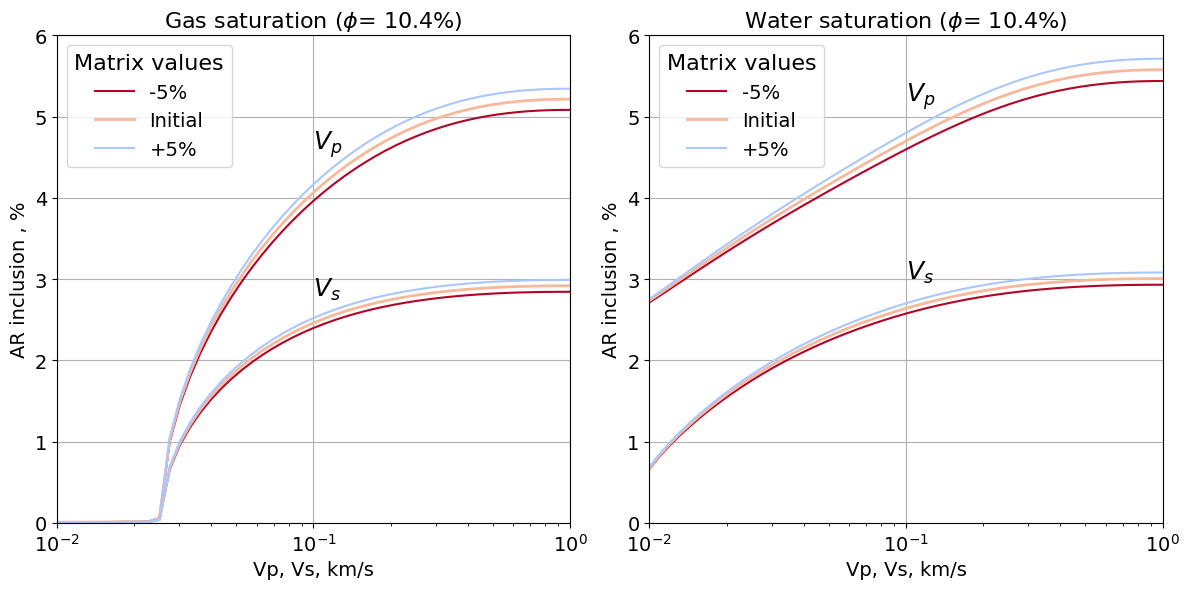

In [ ]:
plt.figure(figsize=(12, 6))

# First Plot - Vp
plt.subplot(1, 2, 1)
x_values = sensetivity_air['AR']
  # Vp
plt.plot(x_values, sensetivity_air['Vp M-'], color='#b40426', label='-5%')
plt.plot(x_values, sensetivity_air['Vp M'], color='#f7b89c',  label='Initial', linewidth=2)
plt.plot(x_values, sensetivity_air['Vp M+'], color='#aac7fd', label='+5%')
  # Vs
plt.plot(x_values, sensetivity_air['Vs M-'], color='#b40426')
plt.plot(x_values, sensetivity_air['Vs M'], color='#f7b89c',linewidth=2)
plt.plot(x_values, sensetivity_air['Vs M+'], color='#aac7fd')

plt.xlabel('Vp, Vs, km/s', fontsize=14)  # Set x label font to Arial
plt.ylabel('AR inclusion , %', fontsize=14)  # Set y label font to Arial
plt.title('Gas saturation ($\phi$= 10.4%)', fontsize=16)  # Set title font to Arial

plt.xticks(fontsize=14)  # Set x ticks font to Arial
plt.yticks(fontsize=14)  # Set y ticks font to Arial

plt.text(10**-1, 4.6, '$V_{p}$', fontsize=18, style='italic')
plt.text(10**-1, 2.8, '$V_{s}$', fontsize=18, style='italic')

plt.legend(title=r'Matrix values', fontsize=14, title_fontsize=16, loc='upper left')

plt.xscale("log")
plt.ylim(0, 6)
plt.xlim(10**-2, 10**0)
plt.grid()

# Second Plot - Vs
plt.subplot(1, 2, 2)
x_values = sensetivity_water['AR']
  # Vp
plt.plot(x_values, sensetivity_water['Vp M-'], color='#b40426', label='-5%')
plt.plot(x_values, sensetivity_water['Vp M'], color='#f7b89c',  label='Initial', linewidth=2)
plt.plot(x_values, sensetivity_water['Vp M+'], color='#aac7fd', label='+5%')
  # Vs
plt.plot(x_values, sensetivity_water['Vs M-'], color='#b40426')
plt.plot(x_values, sensetivity_water['Vs M'], color='#f7b89c',linewidth=2)
plt.plot(x_values, sensetivity_water['Vs M+'], color='#aac7fd')

plt.xlabel('Vp, Vs, km/s', fontsize=14)  # Set x label font to Arial
plt.ylabel('AR inclusion , %', fontsize=14)  # Set y label font to Arial
plt.title('Water saturation ($\phi$= 10.4%)', fontsize=16)  # Set title font to Arial

plt.xticks(fontsize=14)  # Set x ticks font to Arial
plt.yticks(fontsize=14)  # Set y ticks font to Arial

# Add description to the plot
plt.text(10**-1, 5.2, '$V_{p}$', fontsize=18, style='italic')
plt.text(10**-1, 3, '$V_{s}$', fontsize=18, style='italic')

plt.legend(title=r'Matrix values', fontsize=14, title_fontsize=16, loc='upper left')

plt.xscale("log")
plt.ylim(0, 6)
plt.xlim(10**-2, 10**0)
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
fluid_list = ['air', 'water']
for fluid in fluid_list:
    globals()[f'{fluid}'][f'Diff Vp {fluid}'] = globals()[f'{fluid}'][['Vp M+', 'Vp M-']].apply(lambda x: np.round((x['Vp M+'] - x['Vp M-']) / x['Vp M-'] * 100, 2), axis=1)
    globals()[f'{fluid}'][f'Diff Vs {fluid}'] = globals()[f'{fluid}'][[f'Vs M+', f'Vs M-']].apply(lambda x: np.round((x['Vs M+'] - x['Vs M-']) / x['Vs M-'] * 100, 2), axis=1)

## Sensetivity study: Porosity VS Aspect ratio

In [ ]:
# sensetivity_air = pd.DataFrame()
sensetivity_water = pd.DataFrame()

In [ ]:
# Input data
porosity_list = np.linspace(0, 0.25, 21)
# AR = np.logspace(-2, 0, num=51) ### Range 0.01 - 1

### Matrix
K_air_mtrx, Mu_air_mtrx = 53.91373366666666, 27.232519
K_water_mtrx, Mu_water_mtrx = 63.66756566666667, 28.624375

### Fluid
K_oil, Mu_oil, p_oil = 0.26, 10**-12, 1.04
K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air

In [ ]:
Vp_fluid_list = []
Vs_fluid_list = []
AR_list = []

ar_inclusion = 0.5

for porosity in porosity_list:

      AR_inclusion = ar_inclusion
      AR_mtrx = 1.00001

      AR_list.append(ar_inclusion)

      K_matrix, Mu_matrix = K_water_mtrx, Mu_water_mtrx
      K_fluid, Mu_fluid = K_water, Mu_water
      density_fluid = p_water

      # K_matrix, Mu_matrix = K_air_mtrx, Mu_air_mtrx
      # K_fluid, Mu_fluid = K_water, Mu_air
      # density_fluid = p_air

      K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion, K_matrix, Mu_matrix, K_fluid, Mu_fluid, porosity)
      density_mtrx, density_fluid = 2.71, density_fluid
      Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

      Vp_fluid_list.append(Vp)
      Vs_fluid_list.append(Vs)

In [ ]:
# sensetivity_air['Porosity'] = porosity_list
# sensetivity_air['Vp AR 0.5'] = Vp_fluid_list
# sensetivity_air['Vs AR 0.5'] = Vs_fluid_list

In [ ]:
# sensetivity_water['Porosity'] = porosity_list
sensetivity_water['Vp AR 0.5'] = Vp_fluid_list
sensetivity_water['Vs AR 0.5'] = Vs_fluid_list

In [ ]:
sensetivity_water[:10]

,Porosity,Vp AR 0.05,Vs AR 0.05,Vp AR 0.1,Vs AR 0.1,Vp AR 0.5,Vs AR 0.5
0,0.0000,6.130000,3.250000,6.130000,3.250000,6.130000,3.250000
1,0.0125,5.805511,3.127533,5.924772,3.178459,6.059112,3.221084
2,0.0250,5.518632,3.007131,5.732198,3.106320,5.987433,3.191447
3,0.0375,5.259715,2.888948,5.550046,3.033645,5.914921,3.161060
4,0.0500,5.022449,2.773003,5.376596,2.960480,5.841531,3.129890
5,0.0625,4.802488,2.659234,5.210497,2.886853,5.767215,3.097904
6,0.0750,4.596709,2.547533,5.050674,2.812787,5.691925,3.065067
7,0.0875,4.402795,2.437764,4.896260,2.738291,5.615610,3.031339
8,0.1000,4.218979,2.329779,4.746548,2.663372,5.538215,2.996682
9,0.1125,4.043885,2.223426,4.600957,2.588029,5.459683,2.961051


In [ ]:
# sensetivity_air.to_csv('/content/Sensetivity_air_Berryman_AR.csv', index=False)
sensetivity_water.to_csv('/content/Sensetivity_water_Berryman_AR.csv', index=False)

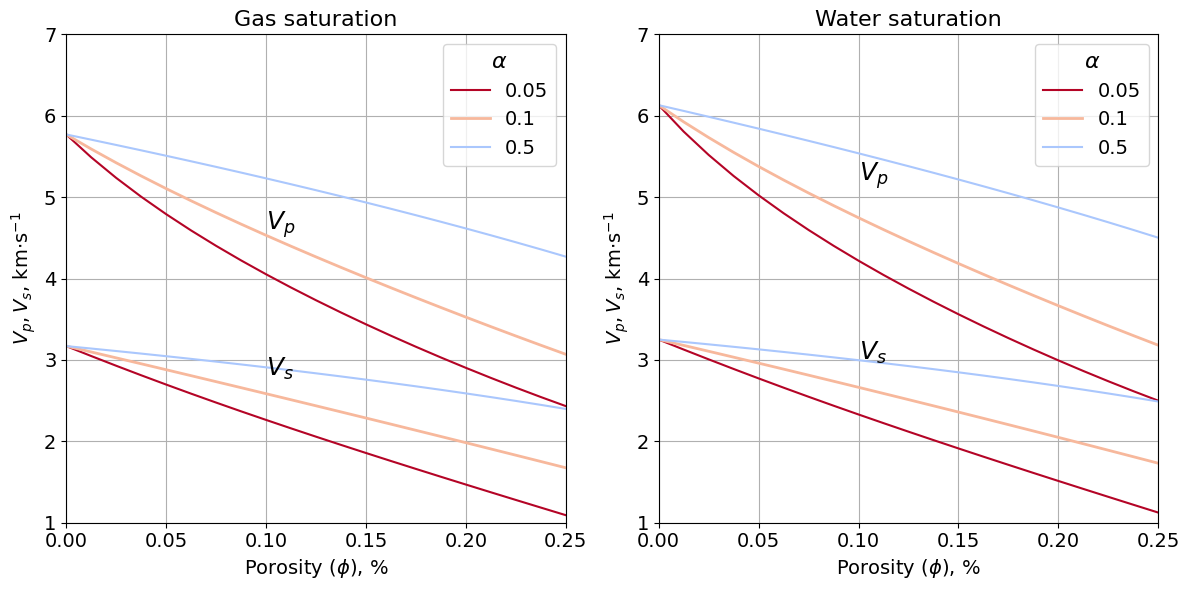

In [ ]:
plt.figure(figsize=(12, 6))

# First Plot - Vp
plt.subplot(1, 2, 1)
x_values = sensetivity_air['Porosity']
  # Vp
plt.plot(x_values, sensetivity_air['Vp AR 0.05'], color='#b40426', label='0.05')
plt.plot(x_values, sensetivity_air['Vp AR 0.1'], color='#f7b89c',  label='0.1', linewidth=2)
plt.plot(x_values, sensetivity_air['Vp AR 0.5'], color='#aac7fd', label='0.5')
  # Vs
plt.plot(x_values, sensetivity_air['Vs AR 0.05'], color='#b40426')
plt.plot(x_values, sensetivity_air['Vs AR 0.1'], color='#f7b89c',linewidth=2)
plt.plot(x_values, sensetivity_air['Vs AR 0.5'], color='#aac7fd')

plt.xlabel('Porosity $(\phi)$, %', fontsize=14)  # Set x label font to Arial
plt.ylabel('$V_{p}, V_{s}$, km$\cdot$s$^{-1}$', fontsize=14)  # Set y label font to Arial
plt.title('Gas saturation', fontsize=16)  # Set title font to Arial

plt.xticks(fontsize=14)  # Set x ticks font to Arial
plt.yticks(fontsize=14)  # Set y ticks font to Arial

plt.text(10**-1, 4.6, '$V_{p}$', fontsize=18, style='italic')
plt.text(10**-1, 2.8, '$V_{s}$', fontsize=18, style='italic')

plt.legend(title=r'$\alpha$', fontsize=14, title_fontsize=16, loc='upper right')

plt.ylim(1, 7)
plt.xlim(0, 0.25)
plt.grid()

# Second Plot - Vs
plt.subplot(1, 2, 2)
x_values = sensetivity_air['Porosity']
  # Vp
plt.plot(x_values, sensetivity_water['Vp AR 0.05'], color='#b40426', label='0.05')
plt.plot(x_values, sensetivity_water['Vp AR 0.1'], color='#f7b89c',  label='0.1', linewidth=2)
plt.plot(x_values, sensetivity_water['Vp AR 0.5'], color='#aac7fd', label='0.5')
  # Vs
plt.plot(x_values, sensetivity_water['Vs AR 0.05'], color='#b40426')
plt.plot(x_values, sensetivity_water['Vs AR 0.1'], color='#f7b89c',linewidth=2)
plt.plot(x_values, sensetivity_water['Vs AR 0.5'], color='#aac7fd')

plt.xlabel('Porosity $(\phi)$, %', fontsize=14)  # Set x label font to Arial
plt.ylabel('$V_{p}, V_{s}$, km$\cdot$s$^{-1}$', fontsize=14)  # Set y label font to Arial
plt.title('Water saturation', fontsize=16)  # Set title font to Arial

plt.xticks(fontsize=14)  # Set x ticks font to Arial
plt.yticks(fontsize=14)  # Set y ticks font to Arial

# Add description to the plot
plt.text(10**-1, 5.2, '$V_{p}$', fontsize=18, style='italic')
plt.text(10**-1, 3, '$V_{s}$', fontsize=18, style='italic')

plt.legend(title=r'$\alpha$', fontsize=14, title_fontsize=16, loc='upper right')

plt.ylim(1, 7)
plt.xlim(0, 0.25)
plt.grid()

plt.tight_layout()
plt.show()

# Direct problem: Elastisity from Thermal conductivity

In [81]:
path_to_ser = Path('/content/NewElastic/Tver_book.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties', skiprows=0)

In [ ]:
df_ues.dropna(subset=['Porosity,%', 'AR thermal'], inplace=True)

In [82]:
df_ues.columns

Index(['#', 'Sample', 'Well', 'Litholohy', 'Porosity,%', 'Permeability',
       'Density (air)', 'Mineralogical density', 'Density (water)',
       'Density (oil)', 'Vp air', 'Vs air', 'Vp oil', 'Vs oil', 'Vp water',
       'Vs water', 'Unnamed: 16', 'AR thermal', 'AO electrical', 'Unnamed: 19',
       'Unnamed: 20', 'TC avg', 'TCav', 'TCav.1', 'TCav.2', 'TCav.3', 'TCav.4',
       'Porosity,%.1', 'Permeability_calc', 'Permeability_fluid',
       'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33',
       'Kozeney-Carman', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37',
       'Unnamed: 38'],
      dtype='object')

In [83]:
data = df_ues[['Porosity,%', 'AR thermal', 'AO electrical',  'Vp air', 'Vs air', 'Vp water', 'Vs water', 'Vp oil',
       'Vs oil']]

In [124]:
Vp_reg_air, Vs_reg_air = 5.77, 3.17
Vp_reg_water, Vs_reg_water = 6.13, 3.25
Vp_reg_oil, Vs_reg_oil = 6.19, 3.39

Vp_reg_water, Vs_reg_water = 5.98, 3.28


K_air_mtrx, Mu_air_mtrx = velosity2modulus(2.71, Vp_reg_air, Vs_reg_air)
K_water_mtrx, Mu_water_mtrx = velosity2modulus(2.71, Vp_reg_water, Vs_reg_water)
K_oil_mtrx, Mu_oil_mtrx = velosity2modulus(2.71, Vp_reg_oil, Vs_reg_oil)


K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air
K_oil, Mu_oil, p_oil = 1, 10**-12, 1.04

density_air, density_water, density_oil = p_air, p_water, p_oil

90.22375899999999 27.232519 53.91373366666666 27.232519
96.910684 29.155263999999995 58.036998666666676 29.155263999999995
103.83663100000001 31.143591 62.31184300000001 31.143591


In [122]:
def table_calclation_elastic(fluid_list, k, mu):

  p_air, p_water, p_oil = 1.22, 1.01, 0.78

  for fluid in fluid_list:

    if fluid=='air':
      density_fluid = p_air
      K_fluid, Mu_fluid = K_air, Mu_air
    elif fluid == 'water':
      density_fluid = p_water
      K_fluid, Mu_fluid = K_water, Mu_water
    elif fluid == 'oil':
      density_fluid = p_oil
      K_fluid, Mu_fluid = K_oil, Mu_oil

    print(density_fluid, K_fluid, Mu_fluid )


    data_fluid = {

    }

    Vp_fluid_list = []
    Vs_fluid_list = []

    globals()[f'result_{fluid}'] = pd.DataFrame(data_fluid)
    globals()[f'sorted_{fluid}'] = pd.DataFrame(data_fluid)

    for porosity, ar_inclusion in zip(data['Porosity,%']/100, np.round(data['AR thermal'], 2)):

      AR_inclusion = ar_inclusion
      AR_mtrx = 1.00001

### Matrix
      # K_matrix, Mu_matrix = globals()[f"K_{fluid}_mtrx"], globals()[f"Mu_{fluid}_mtrx"]
      K_matrix, Mu_matrix = k, mu

      K, Mu = main_Berryman_common(AR_mtrx, AR_inclusion,
                                    K_matrix, Mu_matrix,
                                    K_fluid, Mu_fluid,
                                    porosity)
      density_mtrx = 2.71
      Vp, Vs = modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)


      Vp_fluid_list.append(Vp)
      Vs_fluid_list.append(Vs)


    globals()[f'result_{fluid}'][f'Porosity,%'] = data['Porosity,%']/100
    # globals()[f'result_{fluid}'][f'AR inclusion'] = np.round(data['AR thermal'], 2)
    globals()[f'result_{fluid}'][f'AR inclusion'] = np.round(data['AO electrical'], 2)
    globals()[f'result_{fluid}'][f'Vp_{fluid}'] = Vp_fluid_list
    globals()[f'result_{fluid}'][f'Vs_{fluid}'] = Vs_fluid_list

    globals()[f'result_{fluid}'][f'Vp_exp_{fluid}'] = data[f'Vp {fluid}']
    globals()[f'result_{fluid}'][f'Vs_exp_{fluid}'] = data[f'Vs {fluid}']

        # Assuming 'fluid' is a placeholder for the specific fluid you are working with
    # fluid = 'air'

    # Calculate the difference and assign it directly to the new column 'Diff Vp air'
    Vp_exp = globals()[f'result_{fluid}'][f'Vp_exp_{fluid}']
    Vs_exp = globals()[f'result_{fluid}'][f'Vs_exp_{fluid}']
    globals()[f'result_{fluid}'][f'Diff Vp {fluid}'] = np.round((globals()[f'result_{fluid}'][f'Vp_{fluid}'] - Vp_exp) / Vp_exp * 100, 2)
    globals()[f'result_{fluid}'][f'Diff Vs {fluid}'] = np.round((globals()[f'result_{fluid}'][f'Vs_{fluid}'] - Vs_exp) / Vs_exp * 100, 2)


    globals()[f'sorted_{fluid}'] = globals()[f'result_{fluid}'][(globals()[f'result_{fluid}'][f'Diff Vp {fluid}'].abs() > 10) & \
  (globals()[f'result_{fluid}'][f'Diff Vs {fluid}'].abs() > 10)].sort_values(by=[f'Diff Vp {fluid}', f'Diff Vs {fluid}'], key=lambda x: x.abs())



  # print (globals()[f'sorted_{fluid}'])


  # Vp_exp = globals()[f'result_{fluid}'][f'Vp_exp_{fluid}']

  # globals()[f'result_{fluid}'][f'Diff Vp {fluid}'] = globals()[f'result_{fluid}'][[f'Vp_{fluid}']]\
  #  .apply(lambda x: np.round((x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)

  # print(globals()[f'sorted_{fluid}'].shape[1])

  return globals()[f'sorted_{fluid}'].shape[0]



## Finding $K$, $\mu$ mineral matrix

In [ ]:
K,  Mu, porosity = 53.91373366666666, 27.232519, 0
density_mtrx, density_fluid = 2.71, p_water
modulus2velosity(density_mtrx, density_fluid, porosity, K, Mu)

(5.77, 3.17)

In [94]:
fluid_list = ['air', 'water', 'oil']



K_air_mtrx, Mu_air_mtrx = 53.91373366666666, 27.232519
K_water_mtrx, Mu_water_mtrx = 63.66756566666667, 28.624375
K_oil_mtrx, Mu_oil_mtrx = 63.66756566666667, 28.624375

error_air, error_water, error_oil = 0.1, 0.1, 0.1 # Error for K, mu minreal matrix
N = 2

for fluid in fluid_list:

  print(fluid, globals()[f"K_{fluid}_mtrx"], globals()[f"Mu_{fluid}_mtrx"])

  globals()[f"K_{fluid}_list_mtrx"] = np.linspace(globals()[f"K_{fluid}_mtrx"] - globals()[f"K_{fluid}_mtrx"] * globals()[f"error_{fluid}"],
                                                  globals()[f"K_{fluid}_mtrx"] + globals()[f"K_{fluid}_mtrx"] * globals()[f"error_{fluid}"],
                                                  N)

  globals()[f"Mu_{fluid}_list_mtrx"] = np.linspace(globals()[f"Mu_{fluid}_mtrx"] - globals()[f"Mu_{fluid}_mtrx"] * globals()[f"error_{fluid}"],
                                                   globals()[f"Mu_{fluid}_mtrx"] + globals()[f"Mu_{fluid}_mtrx"] * globals()[f"error_{fluid}"],
                                                   N)

  for k, mu in zip(globals()[f"K_{fluid}_list_mtrx"], globals()[f"Mu_{fluid}_list_mtrx"]):

    number = table_calclation_elastic(fluid_list, k, mu)

    print(globals()[f"error_{fluid}"], k, mu, number)

  print('\n\n')

air 53.91373366666666 27.232519
1.22 1e-06 1e-06
1.01 2.25 1e-20
0.78 0.26 1e-12
0.1 48.52236029999999 24.5092671 10
1.22 1e-06 1e-06
1.01 2.25 1e-20
0.78 0.26 1e-12
0.1 59.30510703333333 29.9557709 3



water 63.66756566666667 28.624375
1.22 1e-06 1e-06
1.01 2.25 1e-20
0.78 0.26 1e-12
0.1 57.3008091 25.761937500000002 6
1.22 1e-06 1e-06
1.01 2.25 1e-20
0.78 0.26 1e-12
0.1 70.03432223333334 31.4868125 5



oil 63.66756566666667 28.624375
1.22 1e-06 1e-06
1.01 2.25 1e-20
0.78 0.26 1e-12
0.1 57.3008091 25.761937500000002 6
1.22 1e-06 1e-06
1.01 2.25 1e-20
0.78 0.26 1e-12
0.1 70.03432223333334 31.4868125 5





## (1) Save the reselt of prediction, (2) Plot Exp-Calculation

56.41532739333334 26.970311892499996
1.22 1e-06 1e-06
1.01 2.25 1e-20
0.78 1 1e-12


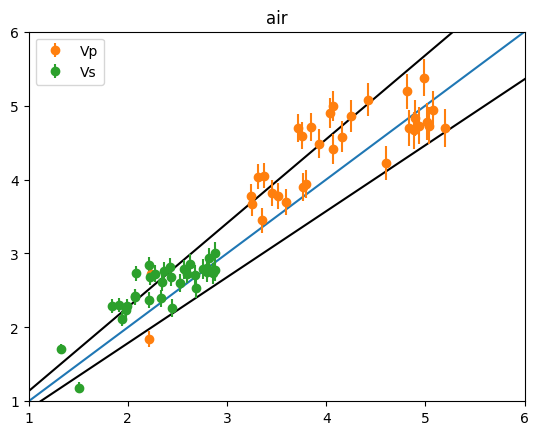




1.22 1e-06 1e-06
1.01 2.25 1e-20
0.78 1 1e-12


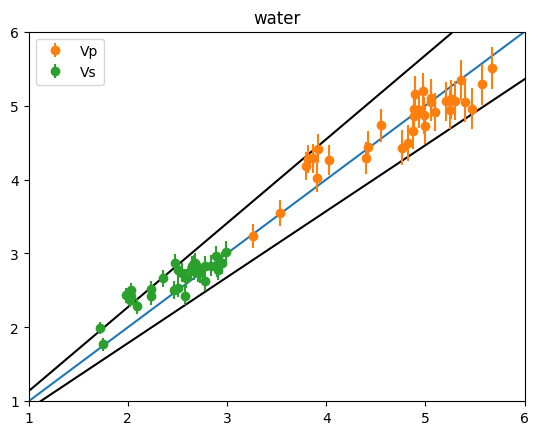




1.22 1e-06 1e-06
1.01 2.25 1e-20
0.78 1 1e-12


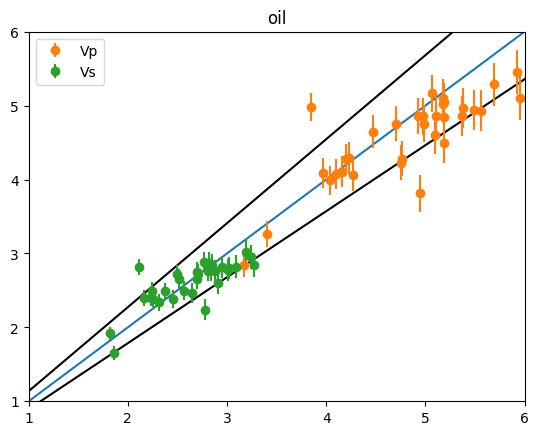

In [127]:
fluid_list = ['air', 'water','oil']

# Calculated k, mu mineral matrix
# K_air_mtrx, Mu_air_mtrx = 43.13, 21.79
# K_water_mtrx, Mu_water_mtrx = 50.93, 22.899
# K_oil_mtrx, Mu_oil_mtrx = 50.93, 22.899

# K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
# K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air
# K_oil, Mu_oil, p_oil = 0.26, 10**-12, 1.04

# p_air, p_water, p_oil = 1.22, 1.01, 0.78
density_air, density_water, density_oil = 1.20, 1.01, 0.85

error = -0.03

km, mum = 58.16013133333334+58.16013133333334*error, 27.804445249999997+27.804445249999997*error
print(km, mum)

K_air_mtrx, Mu_air_mtrx = km, mum
K_water_mtrx, Mu_water_mtrx = km, mum
K_oil_mtrx, Mu_oil_mtrx = km, mum

for fluid in fluid_list:

  k, mu = globals()[f"K_{fluid}_mtrx"], globals()[f"Mu_{fluid}_mtrx"]
  table_calclation_elastic(fluid_list, k, mu)
  globals()[f'result_{fluid}'].to_csv(f'/content/{fluid}.csv', index=True)

  er = 0.12
  plt.plot([0, 6], [0,6])
  plt.plot([0-0*er, 6-6*er], [0,6], color='black')
  plt.plot([0+0*er, 6+6*er], [0,6], color='black')

  c_vp = 0.05*globals()[f'result_{fluid}'][f'Vp_exp_{fluid}']
  c_vs = 0.05*globals()[f'result_{fluid}'][f'Vs_exp_{fluid}']

  plt.errorbar(globals()[f'result_{fluid}'][f'Vp_exp_{fluid}'],
               globals()[f'result_{fluid}'][f'Vp_{fluid}'],
               yerr=c_vp, fmt="o", label='Vp')

  plt.errorbar(globals()[f'result_{fluid}'][f'Vs_exp_{fluid}'],
               globals()[f'result_{fluid}'][f'Vs_{fluid}'],
               yerr=c_vs, fmt="o", label='Vs')

  plt.title(f'{fluid}')

  plt.xlim(1, 6)
  plt.ylim(1, 6)
  plt.legend()
  plt.show()
  print('\n\n')

# Direct problem: Thermal conductivity from Elastisity

In [128]:
path_to_ser = Path('/content/NewElastic/Tver_book.xlsx')
df_ues_ar = pd.read_excel(path_to_ser, sheet_name='Berriman_inverse', skiprows=0)

In [129]:
df_ues_ar.columns

Index(['#', 'Sample', 'Well', 'Litholohy', 'Porosity,%', 'Permeability',
       'Density (air)', 'Mineralogical density', 'Density (water)',
       'Density (oil)', 'Vp air', 'Vs air', 'Vp oil', 'Vs oil', 'Vp water',
       'Vs water', 'Unnamed: 16', 'AR thermal', 'AO electrical', 'Unnamed: 19',
       'Unnamed: 20', 'TC air', 'TC oil', 'TC 0,6', 'TC 6', 'TC 60', 'TC 180',
       'Unnamed: 27', 'Porosity,%.1', 'AR thermal.1', 'AR elastic Berriman',
       'Crack density ', 'K matrx air', 'Mu matrx air', 'Vp air.1', 'Vs air.1',
       'K matrx water', 'Mu matrx water', 'Vp water.1', 'Vp water.2',
       'Diff Vp air', 'Diff Vs air', 'Diff Vp water', 'Diff Vs water',
       'Comments', 'Unnamed: 45', 'Porosity,%.2', 'Unnamed: 47', 'Unnamed: 48',
       'AR elastic GSA', 'C11_air', 'C12_air', 'C44_air', 'Vp air.2',
       'Vs air.2', 'C11_water', 'C12_water', 'C44_water', 'Vp water.3',
       'Vs water.1', 'Diff Vp air.1', 'Diff Vs air.1', 'Diff Vp water.1',
       'Diff Vs water.1'],
   

In [130]:
df_ues_ar.dropna(subset=['Porosity,%', 'AR thermal', 'AR elastic Berriman'], inplace=True)

In [131]:
df_ues_ar.rename(columns={'TC 6': 'TC water'}, inplace=True)

In [132]:
data = df_ues_ar[['Porosity,%', 'AR thermal', 'AO electrical', 'AR elastic Berriman', 'TC air', 'TC oil', 'TC water']]

In [133]:
def effective_tc(conc, alpha_shape, lam):

    x0=0

    phi = conc

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))

    L0 = lam[0]

    def raschet(L0):

        parall_comp, perpen_comp = [], []
#         print('Тело сравнения', L0)

        for i, j, f in zip(phi, lam, depolar_F):

#             print('Каждая комопонента')
#             print(i, j, f)

            termc_3 = i * j / (L0 * (1-f)+j * f)
            termz_3 = i / (L0 * (1-f)+j * f)

            termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
            termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

            termc_all = (termc_3+2 * termc_12) / 3
            termz_all = (termz_3+2 * termz_12) / 3

            t16 = termc_all # числитель
            t15 = termz_all # Знаменатель

#             print('ТС матрицы', j)
#             print('t16:' , t16)
#             print('t15:' , t15)

            parall_comp.append(t16)  # числитель формулы (матрица, флюид)
            perpen_comp.append(t15)  # знаменатель формулы (матрица, флюид)

#         print('Параллельный компоненты ТС', parall_comp)
#         print('Перпендикулярные компоненты ТС', perpen_comp)

        L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
#         print('TC eff: ', L_eff, end='\n\n')
        return L_eff

    x0 = L0
    L0 = raschet(x0)
    it_f = 1
    while abs(x0-L0) >= 10 **-6:
        x0 = L0
        L0 = raschet(x0)
        it_f += 1

#     print('Количество итераций: ', it_f, end='\n\n')
    return L0
#     print('Эффективное значение TC_eff:', raschet(L0))


In [157]:
def table_calclation(fluid_list, lam_matrix):

  for fluid in fluid_list:

      data_fluid = {

      }

      tc_eff_list = []

      globals()[f'result_{fluid}'] = pd.DataFrame(data_fluid)
      globals()[f'sorted_{fluid}'] = pd.DataFrame(data_fluid)

      if fluid=='air':
        lam_fluid = 0.025
      elif fluid == 'water':
        lam_fluid = 0.60

      elif fluid == 'oil':
        lam_fluid = 0.12

      print(lam_fluid)


      for porosity, ar_inclusion in zip(data['Porosity,%']/100, np.round(data['AR elastic Berriman'], 2)):

        conc = [1-porosity, porosity]
        alpha_shape = [1, ar_inclusion]
        lam = [globals()[f"lam_mtrx_{fluid}"], lam_fluid]

        lam_eff = effective_tc(conc, alpha_shape, lam)

        tc_eff_list.append(lam_eff)

      globals()[f'result_{fluid}'][f'Porosity,%'] = data['Porosity,%']/100
      # globals()[f'result_{fluid}'][f'AR inclusion'] = np.round(data['AR thermal'], 2)
      globals()[f'result_{fluid}'][f'AR inclusion'] = np.round(data['AR elastic Berriman'], 2)
      globals()[f'result_{fluid}'][f'TC_{fluid}'] = tc_eff_list

      globals()[f'result_{fluid}'][f'TC_exp_{fluid}'] = data[f'TC {fluid}']


      # Calculate the difference and assign it directly to the new column 'Diff Vp air'
      TC_exp = globals()[f'result_{fluid}'][f'TC_exp_{fluid}']
      globals()[f'result_{fluid}'][f'Diff TC {fluid}'] = np.round((globals()[f'result_{fluid}'][f'TC_{fluid}'] - TC_exp) / TC_exp * 100, 2)

      globals()[f'sorted_{fluid}'] = globals()[f'result_{fluid}'][(globals()[f'result_{fluid}'][f'Diff TC {fluid}'].abs() > 5) & \
    (globals()[f'result_{fluid}'][f'Diff TC {fluid}'].abs() > 5)].sort_values(by=[f'Diff TC {fluid}', f'Diff TC {fluid}'], key=lambda x: x.abs())

      return globals()[f'sorted_{fluid}'].shape[0]

In [153]:
fluid_list = ['air', 'water', 'oil']

lam_air, lam_water, lam_oil = 0.025, 0.6, 0.12
lam_mtrx_air, lam_mtrx_water, lam_mtrx_oil = 2.95, 2.95, 2.95

error_air, error_water, error_oil = 0.05, 0.05, 0.05 # Error for K, mu minreal matrix
N = 1

for fluid in fluid_list:

  print(fluid, globals()[f"lam_mtrx_{fluid}"], globals()[f"lam_{fluid}"])

  globals()[f"lam_mtrx_{fluid}_list"] = np.linspace(globals()[f"lam_mtrx_{fluid}"] - globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  globals()[f"lam_mtrx_{fluid}"] + globals()[f"lam_mtrx_{fluid}"] * globals()[f"error_{fluid}"],
                                                  N)

  for lam_matrix in globals()[f"lam_mtrx_{fluid}_list"] :

    number = table_calclation(fluid_list, lam_matrix)

    print(globals()[f"error_{fluid}"], lam_matrix, number)

  print('\n\n')

air 2.95 0.025
0.025
0.05 2.8025 10



water 2.95 0.6
0.025
0.05 2.8025 10



oil 2.95 0.12
0.025
0.05 2.8025 10





0.025


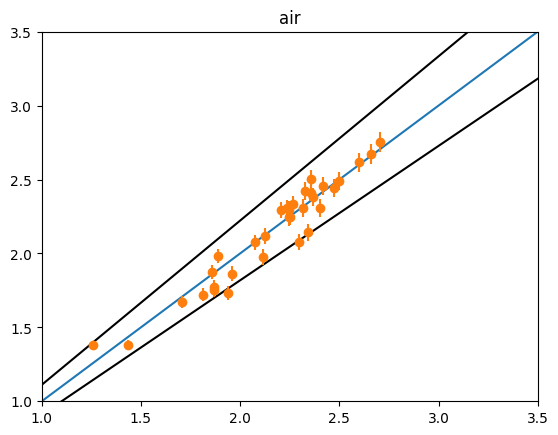




0.025


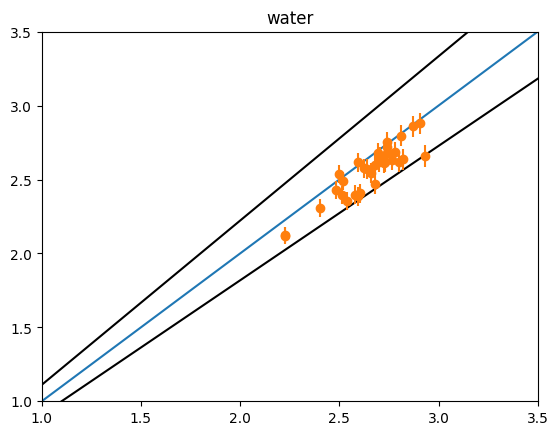




0.025


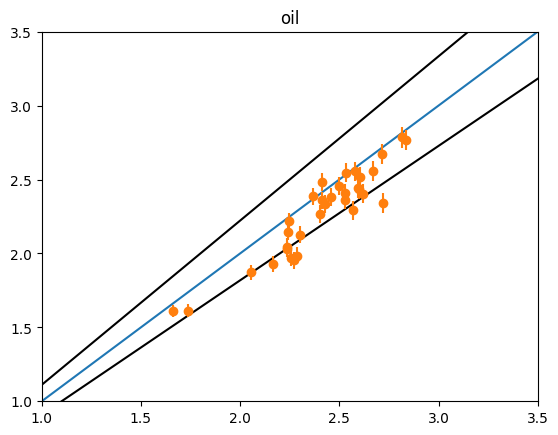

In [156]:
fluid_list = ['air', 'water', 'oil']

# Calculated k, mu mineral matrix
lam_mtrx_air, lam_mtrx_water, lam_mtrx_oil = 2.95, 2.95, 2.95

for fluid in fluid_list:

  lam = globals()[f"lam_mtrx_{fluid}"]
  table_calclation(fluid_list, lam_matrix)
  globals()[f'result_{fluid}'].to_csv(f'/content/{fluid}.csv', index=True)

  er = 0.1
  plt.plot([0, 6], [0,6])
  plt.plot([0-0*er, 6-6*er], [0,6], color='black')
  plt.plot([0+0*er, 6+6*er], [0,6], color='black')

  c = 0.025*globals()[f'result_{fluid}'][f'TC_exp_{fluid}']

  plt.errorbar(globals()[f'result_{fluid}'][f'TC_exp_{fluid}'],
               globals()[f'result_{fluid}'][f'TC_{fluid}'],
               yerr=c, fmt="o")


  plt.title(f'{fluid}')

  plt.xlim(1, 3.5)
  plt.ylim(1, 3.5)
  plt.show()
  print('\n\n')